In [1]:
import os
import math
import time
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
from tqdm import tqdm
from pathlib import Path
import torch.optim as optim
from itertools import cycle
from torchinfo import summary
from datetime import timedelta
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import roc_curve, auc
from torchvision import datasets, transforms
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    matthews_corrcoef, confusion_matrix, classification_report
)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
input_path = Path('/kaggle/input')
for directory in input_path.rglob('*'):
    if directory.is_dir():
        print(directory)

/kaggle/input/Data
/kaggle/input/Data/valid
/kaggle/input/Data/test
/kaggle/input/Data/train
/kaggle/input/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa
/kaggle/input/Data/valid/normal
/kaggle/input/Data/valid/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa
/kaggle/input/Data/valid/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
/kaggle/input/Data/test/squamous.cell.carcinoma
/kaggle/input/Data/test/normal
/kaggle/input/Data/test/adenocarcinoma
/kaggle/input/Data/test/large.cell.carcinoma
/kaggle/input/Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa
/kaggle/input/Data/train/normal
/kaggle/input/Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa
/kaggle/input/Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib


In [ ]:
def compute_normalization_stats(dataset_dir, batch_size=32, num_workers=4, image_size=(224, 224)):
    """
    Compute per-channel mean and std for a dataset.
    Images are resized to a fixed size to avoid collation issues.
    """
    temp_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor()
    ])
    temp_dataset = datasets.ImageFolder(root=dataset_dir, transform=temp_transform)
    temp_loader = DataLoader(
        temp_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    mean = 0.0
    std = 0.0
    nb_samples = 0

    with torch.no_grad():
        for images, _ in temp_loader:
            batch_samples = images.size(0)
            images = images.view(batch_samples, images.size(1), -1)
            mean += images.mean(2).sum(0)
            std += images.std(2).sum(0)
            nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    return mean, std

def create_transforms(mean, std, image_size=(224, 224)):
    """
    Create training and validation/test transforms using computed statistics.
    """
    train_transforms = transforms.Compose([
        transforms.Resize(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean.tolist(), std=std.tolist())
    ])
    
    val_test_transforms = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean.tolist(), std=std.tolist())
    ])
    
    return train_transforms, val_test_transforms

def create_datasets_and_loaders(train_dir, valid_dir, test_dir, train_transforms, val_test_transforms, batch_size=32, num_workers=4):
    """
    Create ImageFolder datasets and DataLoaders with pinned memory.
    """
    train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
    valid_dataset = datasets.ImageFolder(root=valid_dir, transform=val_test_transforms)
    test_dataset  = datasets.ImageFolder(root=test_dir, transform=val_test_transforms)
    
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, 
        num_workers=num_workers, pin_memory=True
    )
    valid_loader = DataLoader(
        valid_dataset, batch_size=batch_size, shuffle=False, 
        num_workers=num_workers, pin_memory=True
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, 
        num_workers=num_workers, pin_memory=True
    )
    
    return train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader

In [5]:
def plot_class_distribution(train_dataset, valid_dataset, test_dataset):
    """
    Plot class distribution across train, validation, and test splits.
    """
    train_targets = np.array(train_dataset.targets)
    valid_targets = np.array(valid_dataset.targets)
    test_targets  = np.array(test_dataset.targets)
    
    classes = train_dataset.classes
    num_classes = len(classes)
    
    train_counts = np.bincount(train_targets, minlength=num_classes)
    valid_counts = np.bincount(valid_targets, minlength=num_classes)
    test_counts  = np.bincount(test_targets, minlength=num_classes)
    
    df = pd.DataFrame({
        'Class': classes,
        'Train': train_counts,
        'Validation': valid_counts,
        'Test': test_counts
    })
    print(df)
    
    x = np.arange(num_classes)
    bar_width = 0.6
    
    plt.figure(figsize=(10, 6))
    plt.bar(x, train_counts, bar_width, color='blue', label='Train')
    plt.bar(x, valid_counts, bar_width, bottom=train_counts, color='green', label='Validation')
    plt.bar(x, test_counts, bar_width, bottom=train_counts + valid_counts, color='red', label='Test')
    
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.xticks(x, classes, rotation=45)
    plt.title('Stacked Class-wise Distribution: Train, Validation, and Test')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
data_dir = '/kaggle/input/Data'
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir  = os.path.join(data_dir, 'test')

In [ ]:
mean, std = compute_normalization_stats(train_dir, batch_size=32, num_workers=4, image_size=(224, 224))
print("Computed Mean:", mean)
print("Computed Std:", std)

train_transforms, val_test_transforms = create_transforms(mean, std, image_size=(224, 224))

batch_size = 16
num_workers = 4
train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = create_datasets_and_loaders(
    train_dir, valid_dir, test_dir, train_transforms, val_test_transforms, batch_size=batch_size, num_workers=num_workers)

print("Training samples:", len(train_dataset))
print("Validation samples:", len(valid_dataset))
print("Test samples:", len(test_dataset))

Computed Mean: tensor([0.3230, 0.3230, 0.3230])
Computed Std: tensor([0.2216, 0.2216, 0.2216])
Training samples: 613
Validation samples: 72
Test samples: 315


                                              Class  Train  Validation  Test
0        adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib    195          23   120
1     large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa    115          21    51
2                                            normal    148          13    54
3  squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa    155          15    90


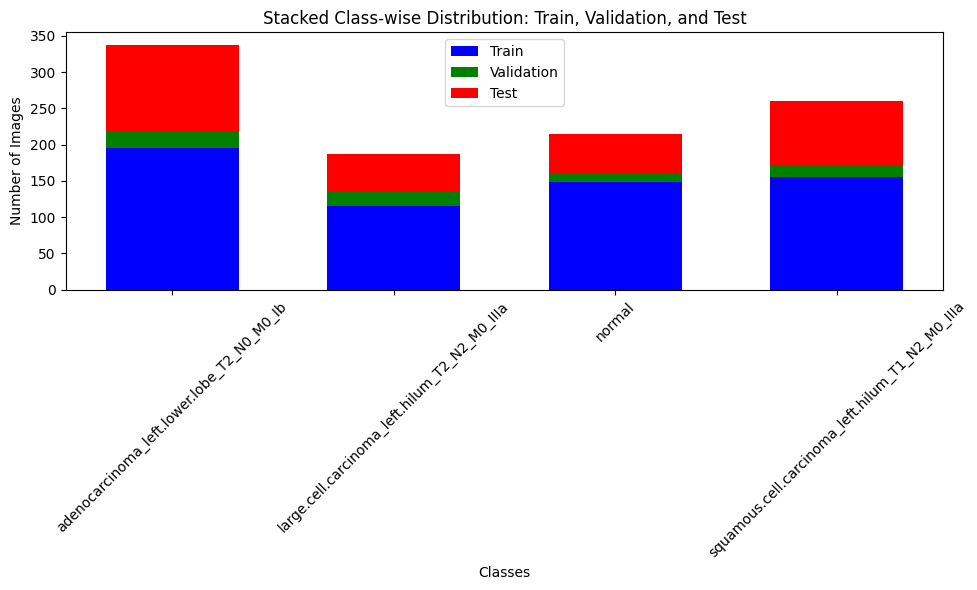

In [ ]:
plot_class_distribution(train_dataset, valid_dataset, test_dataset)

In [ ]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

weights = MobileNet_V2_Weights.IMAGENET1K_V1
model = mobilenet_v2(weights=weights)

num_classes = 4  
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)

model = model.to(device)
summary(model, (1, 3, 224, 224))

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 124MB/s]


Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV2                                        [1, 4]                    --
├─Sequential: 1-1                                  [1, 1280, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                   [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                            [1, 32, 112, 112]         864
│    │    └─BatchNorm2d: 3-2                       [1, 32, 112, 112]         64
│    │    └─ReLU6: 3-3                             [1, 32, 112, 112]         --
│    └─InvertedResidual: 2-2                       [1, 16, 112, 112]         --
│    │    └─Sequential: 3-4                        [1, 16, 112, 112]         896
│    └─InvertedResidual: 2-3                       [1, 24, 56, 56]           --
│    │    └─Sequential: 3-5                        [1, 24, 56, 56]           5,136
│    └─InvertedResidual: 2-4                       [1, 24, 56, 56]           --
│    │    └─Sequential: 3-6   

In [ ]:
def custom_metrics(y_pred, y_true, loss):
    y_pred_classes = torch.argmax(y_pred, dim=1)

    y_true_numpy = y_true.cpu().numpy()
    y_pred_classes_numpy = y_pred_classes.cpu().numpy()

    accuracy = accuracy_score(y_true_numpy, y_pred_classes_numpy)
    precision = precision_score(y_true_numpy, y_pred_classes_numpy, average='weighted', zero_division=0)
    recall = recall_score(y_true_numpy, y_pred_classes_numpy, average='weighted', zero_division=0)
    f1 = f1_score(y_true_numpy, y_pred_classes_numpy, average='weighted', zero_division=0)

    cm = confusion_matrix(y_true_numpy, y_pred_classes_numpy)
    if cm.shape[0] == 2 and cm.shape[1] == 2:
        tn = cm[0, 0]
        fp = cm[0, 1]
        fn = cm[1, 0]
        tp = cm[1, 1]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    else:
        specificity = None
        sensitivity = None

    mcc = matthews_corrcoef(y_true_numpy, y_pred_classes_numpy)

    num_classes = y_pred.shape[1]
    auc_scores = []
    unique_classes = np.unique(y_true_numpy)
    if len(unique_classes) > 1:
        for class_idx in range(num_classes):
            class_y_true = (y_true_numpy == class_idx).astype(np.float32)
            class_y_pred = y_pred[:, class_idx].cpu().numpy()
            if np.all(class_y_true == 0) or np.all(class_y_true == 1):
                continue
            auc_score = roc_auc_score(class_y_true, class_y_pred)
            auc_scores.append(auc_score)
        auc_avg = np.nanmean(auc_scores) if auc_scores else None
    else:
        auc_avg = None

    metrics = {
        "loss": loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "specificity": specificity,
        "sensitivity": sensitivity,
        "mcc": mcc,
        "auc": auc_avg,
    }

    return metrics

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [ ]:
patience = 5
early_stopping_counter = 0
best_val_loss = float('inf')

metric_names = ["loss", "accuracy", "precision", "recall", "f1_score",
                "specificity", "sensitivity", "mcc", "auc"]
train_metrics_history = {metric_name: [] for metric_name in metric_names}
val_metrics_history = {metric_name: [] for metric_name in metric_names}

num_epochs = 25 
total_training_time = 0.0
total_validation_time = 0.0

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    total_loss = 0.0
    all_predictions = []
    all_targets = []
    
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader, desc=f"Training Model - Epoch [{epoch + 1}/{num_epochs}]")):
        data = data.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())
    
    end_time = time.time()
    epoch_training_time = end_time - start_time
    total_training_time += epoch_training_time
    
    average_loss = total_loss / len(train_loader)
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    
    train_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)
    
    training_metrics_line = "Training Metrics - "
    for metric_name, metric_value in train_metrics.items():
        training_metrics_line += f"{metric_name}: {metric_value:.4f}, " if metric_value is not None else f"{metric_name}: N/A, "
    print(training_metrics_line)
    
    for metric_name in metric_names:
        train_metrics_history[metric_name].append(train_metrics[metric_name])
    
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []
    start_time = time.time()
    
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(tqdm(valid_loader, desc="Validating Model")):
            data = data.to(device)
            targets = targets.to(device)
            
            outputs = model(data)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            
            all_predictions.extend(outputs.detach().cpu().numpy())
            all_targets.extend(targets.detach().cpu().numpy())
    
    end_time = time.time()
    epoch_validation_time = end_time - start_time
    total_validation_time += epoch_validation_time
    
    average_val_loss = total_loss / len(valid_loader)
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    
    val_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_val_loss)
    validation_metrics_line = "Validation Metrics - "
    for metric_name, metric_value in val_metrics.items():
        validation_metrics_line += f"{metric_name}: {metric_value:.4f}, " if metric_value is not None else f"{metric_name}: N/A, "
    print(validation_metrics_line)
    
    for metric_name in metric_names:
        val_metrics_history[metric_name].append(val_metrics[metric_name])
    
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        early_stopping_counter = 0
        best_model_state = model.state_dict()
        print(f"Epoch {epoch+1}: New best validation loss: {best_val_loss:.4f}")
    else:
        early_stopping_counter += 1
        print(f"Epoch {epoch+1}: No improvement in validation loss. Patience counter: {early_stopping_counter}/{patience}")
    
    if early_stopping_counter >= patience:
        print("Early stopping triggered. Training terminated.")
        break

print(f"Total Training Time: {str(timedelta(seconds=total_training_time))}")
print(f"Total Validation Time: {str(timedelta(seconds=total_validation_time))}")

avg_training_time_per_epoch = total_training_time / num_epochs
avg_validation_time_per_epoch = total_validation_time / num_epochs
print(f"Average Training Time per Epoch: {str(timedelta(seconds=avg_training_time_per_epoch))}")
print(f"Average Validation Time per Epoch: {str(timedelta(seconds=avg_validation_time_per_epoch))}")

Training Model - Epoch [1/25]: 100%|██████████| 39/39 [00:02<00:00, 13.52it/s]


Training Metrics - loss: 1.2701, accuracy: 0.4078, precision: 0.4433, recall: 0.4078, f1_score: 0.3615, specificity: N/A, sensitivity: N/A, mcc: 0.2480, auc: 0.7019, 


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 11.48it/s]


Validation Metrics - loss: 1.2181, accuracy: 0.4444, precision: 0.5265, recall: 0.4444, f1_score: 0.4034, specificity: N/A, sensitivity: N/A, mcc: 0.2975, auc: 0.6971, 
Epoch 1: New best validation loss: 1.2181


Training Model - Epoch [2/25]: 100%|██████████| 39/39 [00:02<00:00, 16.71it/s]


Training Metrics - loss: 1.0225, accuracy: 0.6085, precision: 0.6111, recall: 0.6085, f1_score: 0.5890, specificity: N/A, sensitivity: N/A, mcc: 0.4913, auc: 0.8228, 


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 13.00it/s]


Validation Metrics - loss: 1.0551, accuracy: 0.5278, precision: 0.5485, recall: 0.5278, f1_score: 0.5230, specificity: N/A, sensitivity: N/A, mcc: 0.3698, auc: 0.7637, 
Epoch 2: New best validation loss: 1.0551


Training Model - Epoch [3/25]: 100%|██████████| 39/39 [00:02<00:00, 16.26it/s]


Training Metrics - loss: 0.9013, accuracy: 0.6672, precision: 0.6599, recall: 0.6672, f1_score: 0.6539, specificity: N/A, sensitivity: N/A, mcc: 0.5555, auc: 0.8520, 


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 12.97it/s]


Validation Metrics - loss: 0.9828, accuracy: 0.5833, precision: 0.6632, recall: 0.5833, f1_score: 0.5820, specificity: N/A, sensitivity: N/A, mcc: 0.4514, auc: 0.7914, 
Epoch 3: New best validation loss: 0.9828


Training Model - Epoch [4/25]: 100%|██████████| 39/39 [00:02<00:00, 16.53it/s]


Training Metrics - loss: 0.7983, accuracy: 0.7406, precision: 0.7431, recall: 0.7406, f1_score: 0.7330, specificity: N/A, sensitivity: N/A, mcc: 0.6513, auc: 0.8946, 


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 12.86it/s]


Validation Metrics - loss: 0.9547, accuracy: 0.6250, precision: 0.6951, recall: 0.6250, f1_score: 0.6161, specificity: N/A, sensitivity: N/A, mcc: 0.5103, auc: 0.8140, 
Epoch 4: New best validation loss: 0.9547


Training Model - Epoch [5/25]: 100%|██████████| 39/39 [00:02<00:00, 16.59it/s]


Training Metrics - loss: 0.7134, accuracy: 0.7732, precision: 0.7778, recall: 0.7732, f1_score: 0.7694, specificity: N/A, sensitivity: N/A, mcc: 0.6948, auc: 0.9156, 


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 12.99it/s]


Validation Metrics - loss: 0.8983, accuracy: 0.6250, precision: 0.6737, recall: 0.6250, f1_score: 0.6150, specificity: N/A, sensitivity: N/A, mcc: 0.5077, auc: 0.8288, 
Epoch 5: New best validation loss: 0.8983


Training Model - Epoch [6/25]: 100%|██████████| 39/39 [00:02<00:00, 16.54it/s]


Training Metrics - loss: 0.6574, accuracy: 0.8091, precision: 0.8108, recall: 0.8091, f1_score: 0.8043, specificity: N/A, sensitivity: N/A, mcc: 0.7439, auc: 0.9265, 


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 13.08it/s]


Validation Metrics - loss: 0.8653, accuracy: 0.6389, precision: 0.7066, recall: 0.6389, f1_score: 0.6274, specificity: N/A, sensitivity: N/A, mcc: 0.5310, auc: 0.8459, 
Epoch 6: New best validation loss: 0.8653


Training Model - Epoch [7/25]: 100%|██████████| 39/39 [00:02<00:00, 15.98it/s]


Training Metrics - loss: 0.5698, accuracy: 0.8303, precision: 0.8405, recall: 0.8303, f1_score: 0.8292, specificity: N/A, sensitivity: N/A, mcc: 0.7731, auc: 0.9444, 


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 12.92it/s]


Validation Metrics - loss: 0.8127, accuracy: 0.6667, precision: 0.7261, recall: 0.6667, f1_score: 0.6588, specificity: N/A, sensitivity: N/A, mcc: 0.5660, auc: 0.8643, 
Epoch 7: New best validation loss: 0.8127


Training Model - Epoch [8/25]: 100%|██████████| 39/39 [00:02<00:00, 16.54it/s]


Training Metrics - loss: 0.5403, accuracy: 0.8499, precision: 0.8565, recall: 0.8499, f1_score: 0.8479, specificity: N/A, sensitivity: N/A, mcc: 0.7996, auc: 0.9537, 


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 12.97it/s]


Validation Metrics - loss: 0.7632, accuracy: 0.6944, precision: 0.7426, recall: 0.6944, f1_score: 0.6929, specificity: N/A, sensitivity: N/A, mcc: 0.5986, auc: 0.8734, 
Epoch 8: New best validation loss: 0.7632


Training Model - Epoch [9/25]: 100%|██████████| 39/39 [00:02<00:00, 16.00it/s]


Training Metrics - loss: 0.4508, accuracy: 0.8793, precision: 0.8808, recall: 0.8793, f1_score: 0.8782, specificity: N/A, sensitivity: N/A, mcc: 0.8376, auc: 0.9696, 


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 10.81it/s]


Validation Metrics - loss: 0.7115, accuracy: 0.7222, precision: 0.7382, recall: 0.7222, f1_score: 0.7200, specificity: N/A, sensitivity: N/A, mcc: 0.6301, auc: 0.8843, 
Epoch 9: New best validation loss: 0.7115


Training Model - Epoch [10/25]: 100%|██████████| 39/39 [00:02<00:00, 15.59it/s]


Training Metrics - loss: 0.4049, accuracy: 0.8972, precision: 0.8980, recall: 0.8972, f1_score: 0.8966, specificity: N/A, sensitivity: N/A, mcc: 0.8618, auc: 0.9736, 


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 12.61it/s]


Validation Metrics - loss: 0.6577, accuracy: 0.7361, precision: 0.7430, recall: 0.7361, f1_score: 0.7346, specificity: N/A, sensitivity: N/A, mcc: 0.6457, auc: 0.8974, 
Epoch 10: New best validation loss: 0.6577


Training Model - Epoch [11/25]: 100%|██████████| 39/39 [00:02<00:00, 16.84it/s]


Training Metrics - loss: 0.3460, accuracy: 0.9152, precision: 0.9162, recall: 0.9152, f1_score: 0.9144, specificity: N/A, sensitivity: N/A, mcc: 0.8862, auc: 0.9806, 


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 13.11it/s]


Validation Metrics - loss: 0.6434, accuracy: 0.7361, precision: 0.7758, recall: 0.7361, f1_score: 0.7355, specificity: N/A, sensitivity: N/A, mcc: 0.6554, auc: 0.9032, 
Epoch 11: New best validation loss: 0.6434


Training Model - Epoch [12/25]: 100%|██████████| 39/39 [00:02<00:00, 16.61it/s]


Training Metrics - loss: 0.3300, accuracy: 0.9347, precision: 0.9346, recall: 0.9347, f1_score: 0.9345, specificity: N/A, sensitivity: N/A, mcc: 0.9120, auc: 0.9841, 


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 13.19it/s]


Validation Metrics - loss: 0.6158, accuracy: 0.7778, precision: 0.7864, recall: 0.7778, f1_score: 0.7788, specificity: N/A, sensitivity: N/A, mcc: 0.7032, auc: 0.9066, 
Epoch 12: New best validation loss: 0.6158


Training Model - Epoch [13/25]: 100%|██████████| 39/39 [00:02<00:00, 16.58it/s]


Training Metrics - loss: 0.2445, accuracy: 0.9608, precision: 0.9608, recall: 0.9608, f1_score: 0.9607, specificity: N/A, sensitivity: N/A, mcc: 0.9472, auc: 0.9917, 


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 13.19it/s]


Validation Metrics - loss: 0.5818, accuracy: 0.8194, precision: 0.8611, recall: 0.8194, f1_score: 0.8253, specificity: N/A, sensitivity: N/A, mcc: 0.7711, auc: 0.9156, 
Epoch 13: New best validation loss: 0.5818


Training Model - Epoch [14/25]: 100%|██████████| 39/39 [00:02<00:00, 16.02it/s]


Training Metrics - loss: 0.2450, accuracy: 0.9462, precision: 0.9463, recall: 0.9462, f1_score: 0.9461, specificity: N/A, sensitivity: N/A, mcc: 0.9274, auc: 0.9895, 


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 12.98it/s]


Validation Metrics - loss: 0.5428, accuracy: 0.8056, precision: 0.8255, recall: 0.8056, f1_score: 0.8081, specificity: N/A, sensitivity: N/A, mcc: 0.7443, auc: 0.9252, 
Epoch 14: New best validation loss: 0.5428


Training Model - Epoch [15/25]: 100%|██████████| 39/39 [00:02<00:00, 16.52it/s]


Training Metrics - loss: 0.1957, accuracy: 0.9723, precision: 0.9724, recall: 0.9723, f1_score: 0.9722, specificity: N/A, sensitivity: N/A, mcc: 0.9626, auc: 0.9939, 


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 13.46it/s]


Validation Metrics - loss: 0.5182, accuracy: 0.8194, precision: 0.8420, recall: 0.8194, f1_score: 0.8211, specificity: N/A, sensitivity: N/A, mcc: 0.7653, auc: 0.9309, 
Epoch 15: New best validation loss: 0.5182


Training Model - Epoch [16/25]: 100%|██████████| 39/39 [00:02<00:00, 16.67it/s]


Training Metrics - loss: 0.1932, accuracy: 0.9706, precision: 0.9710, recall: 0.9706, f1_score: 0.9705, specificity: N/A, sensitivity: N/A, mcc: 0.9605, auc: 0.9948, 


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 12.78it/s]


Validation Metrics - loss: 0.4869, accuracy: 0.8611, precision: 0.8822, recall: 0.8611, f1_score: 0.8642, specificity: N/A, sensitivity: N/A, mcc: 0.8193, auc: 0.9366, 
Epoch 16: New best validation loss: 0.4869


Training Model - Epoch [17/25]: 100%|██████████| 39/39 [00:02<00:00, 16.65it/s]


Training Metrics - loss: 0.1561, accuracy: 0.9853, precision: 0.9853, recall: 0.9853, f1_score: 0.9853, specificity: N/A, sensitivity: N/A, mcc: 0.9802, auc: 0.9971, 


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 11.17it/s]


Validation Metrics - loss: 0.5123, accuracy: 0.8194, precision: 0.8471, recall: 0.8194, f1_score: 0.8214, specificity: N/A, sensitivity: N/A, mcc: 0.7669, auc: 0.9364, 
Epoch 17: No improvement in validation loss. Patience counter: 1/5


Training Model - Epoch [18/25]: 100%|██████████| 39/39 [00:02<00:00, 16.47it/s]


Training Metrics - loss: 0.1256, accuracy: 0.9853, precision: 0.9853, recall: 0.9853, f1_score: 0.9853, specificity: N/A, sensitivity: N/A, mcc: 0.9802, auc: 0.9976, 


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 12.95it/s]


Validation Metrics - loss: 0.4809, accuracy: 0.8611, precision: 0.8768, recall: 0.8611, f1_score: 0.8626, specificity: N/A, sensitivity: N/A, mcc: 0.8175, auc: 0.9384, 
Epoch 18: New best validation loss: 0.4809


Training Model - Epoch [19/25]: 100%|██████████| 39/39 [00:02<00:00, 16.51it/s]


Training Metrics - loss: 0.1334, accuracy: 0.9772, precision: 0.9774, recall: 0.9772, f1_score: 0.9771, specificity: N/A, sensitivity: N/A, mcc: 0.9693, auc: 0.9969, 


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 12.73it/s]


Validation Metrics - loss: 0.4845, accuracy: 0.8333, precision: 0.8617, recall: 0.8333, f1_score: 0.8356, specificity: N/A, sensitivity: N/A, mcc: 0.7857, auc: 0.9394, 
Epoch 19: No improvement in validation loss. Patience counter: 1/5


Training Model - Epoch [20/25]: 100%|██████████| 39/39 [00:02<00:00, 16.56it/s]


Training Metrics - loss: 0.1046, accuracy: 0.9902, precision: 0.9903, recall: 0.9902, f1_score: 0.9902, specificity: N/A, sensitivity: N/A, mcc: 0.9868, auc: 0.9985, 


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]


Validation Metrics - loss: 0.4924, accuracy: 0.8611, precision: 0.8912, recall: 0.8611, f1_score: 0.8663, specificity: N/A, sensitivity: N/A, mcc: 0.8218, auc: 0.9406, 
Epoch 20: No improvement in validation loss. Patience counter: 2/5


Training Model - Epoch [21/25]: 100%|██████████| 39/39 [00:02<00:00, 13.28it/s]


Training Metrics - loss: 0.1025, accuracy: 0.9869, precision: 0.9870, recall: 0.9869, f1_score: 0.9869, specificity: N/A, sensitivity: N/A, mcc: 0.9824, auc: 0.9987, 


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 12.68it/s]


Validation Metrics - loss: 0.4858, accuracy: 0.8611, precision: 0.8912, recall: 0.8611, f1_score: 0.8663, specificity: N/A, sensitivity: N/A, mcc: 0.8218, auc: 0.9443, 
Epoch 21: No improvement in validation loss. Patience counter: 3/5


Training Model - Epoch [22/25]: 100%|██████████| 39/39 [00:02<00:00, 16.54it/s]


Training Metrics - loss: 0.0969, accuracy: 0.9869, precision: 0.9870, recall: 0.9869, f1_score: 0.9869, specificity: N/A, sensitivity: N/A, mcc: 0.9824, auc: 0.9988, 


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 13.36it/s]


Validation Metrics - loss: 0.4214, accuracy: 0.9028, precision: 0.9230, recall: 0.9028, f1_score: 0.9063, specificity: N/A, sensitivity: N/A, mcc: 0.8739, auc: 0.9481, 
Epoch 22: New best validation loss: 0.4214


Training Model - Epoch [23/25]: 100%|██████████| 39/39 [00:02<00:00, 16.61it/s]


Training Metrics - loss: 0.0761, accuracy: 0.9951, precision: 0.9951, recall: 0.9951, f1_score: 0.9951, specificity: N/A, sensitivity: N/A, mcc: 0.9934, auc: 0.9990, 


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 13.14it/s]


Validation Metrics - loss: 0.4782, accuracy: 0.8611, precision: 0.8912, recall: 0.8611, f1_score: 0.8663, specificity: N/A, sensitivity: N/A, mcc: 0.8218, auc: 0.9489, 
Epoch 23: No improvement in validation loss. Patience counter: 1/5


Training Model - Epoch [24/25]: 100%|██████████| 39/39 [00:02<00:00, 16.68it/s]


Training Metrics - loss: 0.0579, accuracy: 0.9935, precision: 0.9935, recall: 0.9935, f1_score: 0.9935, specificity: N/A, sensitivity: N/A, mcc: 0.9912, auc: 0.9996, 


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 11.15it/s]


Validation Metrics - loss: 0.4353, accuracy: 0.9028, precision: 0.9174, recall: 0.9028, f1_score: 0.9048, specificity: N/A, sensitivity: N/A, mcc: 0.8725, auc: 0.9506, 
Epoch 24: No improvement in validation loss. Patience counter: 2/5


Training Model - Epoch [25/25]: 100%|██████████| 39/39 [00:02<00:00, 16.57it/s]


Training Metrics - loss: 0.0761, accuracy: 0.9853, precision: 0.9853, recall: 0.9853, f1_score: 0.9853, specificity: N/A, sensitivity: N/A, mcc: 0.9802, auc: 0.9992, 


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 13.14it/s]

Validation Metrics - loss: 0.4463, accuracy: 0.8889, precision: 0.8999, recall: 0.8889, f1_score: 0.8903, specificity: N/A, sensitivity: N/A, mcc: 0.8531, auc: 0.9512, 
Epoch 25: No improvement in validation loss. Patience counter: 3/5
Total Training Time: 0:01:00.440300
Total Validation Time: 0:00:09.966995
Average Training Time per Epoch: 0:00:02.417612
Average Validation Time per Epoch: 0:00:00.398680


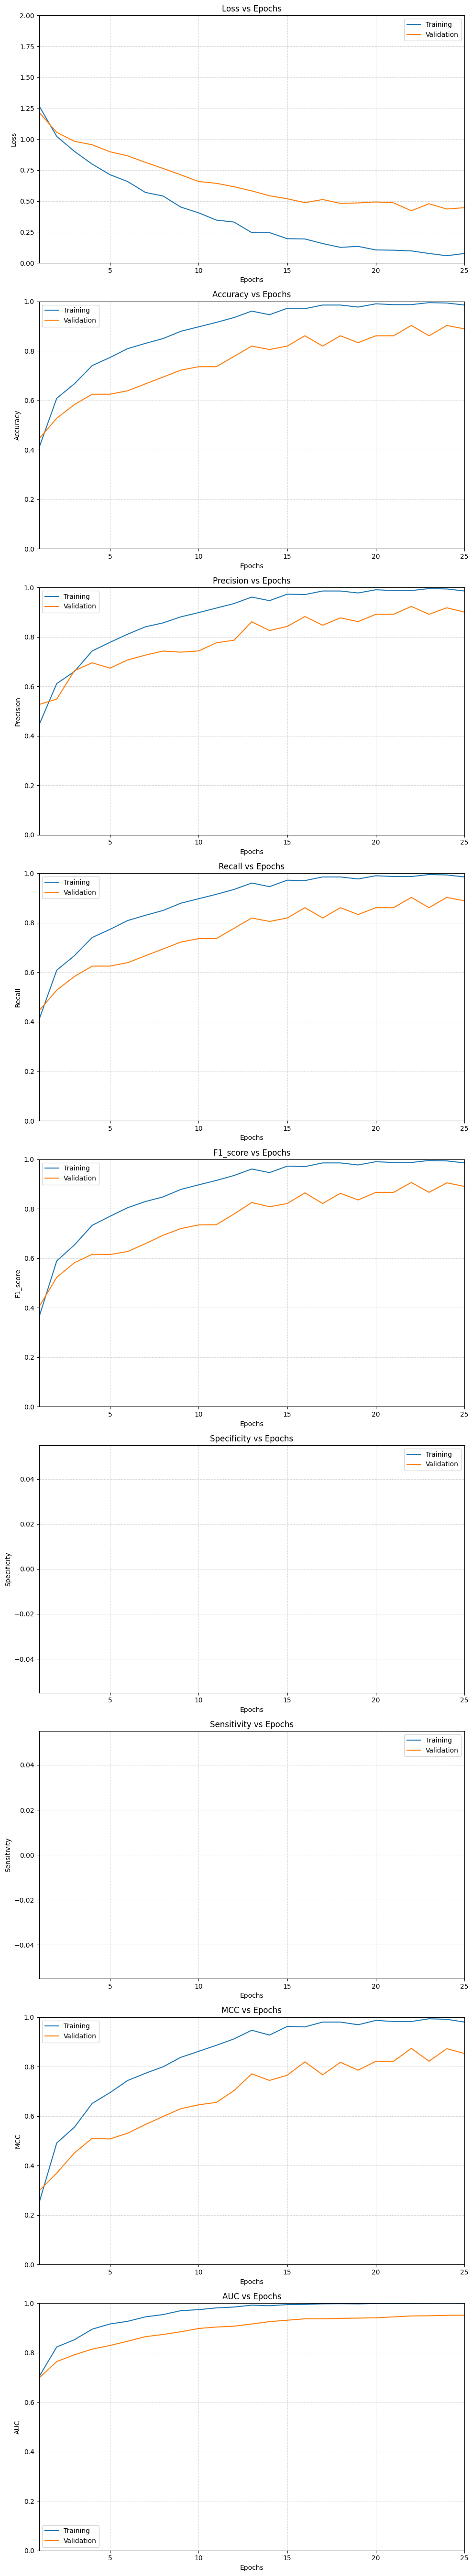

In [ ]:
def plot_metrics(train_metrics_history, val_metrics_history, metric_names):
    num_metrics = len(metric_names)
    num_epochs = len(train_metrics_history[metric_names[0]])
    
    if num_metrics == 1:
        fig, axes = plt.subplots(figsize=(10, 6))
        axes = [axes]
    else:
        fig, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))
    
    rng = range(1, num_epochs + 1)
    
    for ax, metric_name in zip(axes, metric_names):
        train_metric = train_metrics_history[metric_name]
        val_metric = val_metrics_history[metric_name]
        
        ax.plot(rng, train_metric, label="Training")
        ax.plot(rng, val_metric, label="Validation")
        ax.legend()
        ax.set_xlabel("Epochs")
        
        if metric_name in ("auc", "mcc"):
            ax.set_ylabel(metric_name.upper())
            ax.set_title(metric_name.upper() + " vs Epochs")
        else:
            ax.set_ylabel(metric_name.capitalize())
            ax.set_title(metric_name.capitalize() + " vs Epochs")
        
        valid_train = [m for m in train_metric if m is not None]
        valid_val = [m for m in val_metric if m is not None]
        
        if valid_train or valid_val:
            max_metric = max((max(valid_train) if valid_train else float('-inf')),
                             (max(valid_val) if valid_val else float('-inf')))
            min_metric = min((min(valid_train) if valid_train else float('inf')),
                             (min(valid_val) if valid_val else float('inf')))
            y_max = math.ceil(max_metric)
            if min_metric > 0 or max_metric > 1:
                ax.set_ylim(0, y_max)
            else:
                ax.set_ylim(min_metric, y_max)
        
        ax.grid(True, linestyle='--', alpha=0.5)
        if num_epochs > 1:
            ax.set_xlim(1, num_epochs)
    
    plt.tight_layout()
    plt.show()


plot_metrics(train_metrics_history, val_metrics_history, metric_names)

In [14]:
model.eval()
total_loss = 0.0
all_predictions = []
all_targets = []

with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(tqdm(test_loader, desc="Testing Model")):
        data = data.to(device)
        targets = targets.to(device)

        outputs = model(data)
        loss = criterion(outputs, targets)
        total_loss += loss.item()

        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())

all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

average_loss = total_loss / len(test_loader)
test_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

testing_metrics_line = "Metrics - "
for metric_name, metric_value in test_metrics.items():
    if metric_value is None:
        testing_metrics_line += f"{metric_name}: N/A, "
    elif metric_name == 'auc':
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}"
    else:
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}, "

print(testing_metrics_line)

Testing Model: 100%|██████████| 20/20 [00:01<00:00, 14.31it/s]

Metrics - loss: 0.4422, accuracy: 0.8540, precision: 0.8827, recall: 0.8540, f1_score: 0.8589, specificity: N/A, sensitivity: N/A, mcc: 0.8086, auc: 0.9683


In [15]:
true_labels = np.array(all_targets)

predicted_labels = np.argmax(np.array(all_predictions), axis=1)

true_labels = true_labels.astype(int)
predicted_labels = predicted_labels.astype(int)

class_names = train_dataset.classes

report = classification_report(true_labels, predicted_labels, target_names=class_names, digits=4)

accuracy = accuracy_score(true_labels, predicted_labels)
num_errors = np.sum(true_labels != predicted_labels)

print(report)
print(f'There were {num_errors} errors in {len(predicted_labels)} tests for an accuracy of {accuracy*100:6.2f}')

                                                  precision    recall  f1-score   support

      adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib     0.9300    0.7750    0.8455       120
   large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa     0.6125    0.9608    0.7481        51
                                          normal     1.0000    0.9815    0.9907        54
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa     0.9024    0.8222    0.8605        90

                                        accuracy                         0.8540       315
                                       macro avg     0.8612    0.8849    0.8612       315
                                    weighted avg     0.8827    0.8540    0.8589       315

There were 46 errors in 315 tests for an accuracy of  85.40


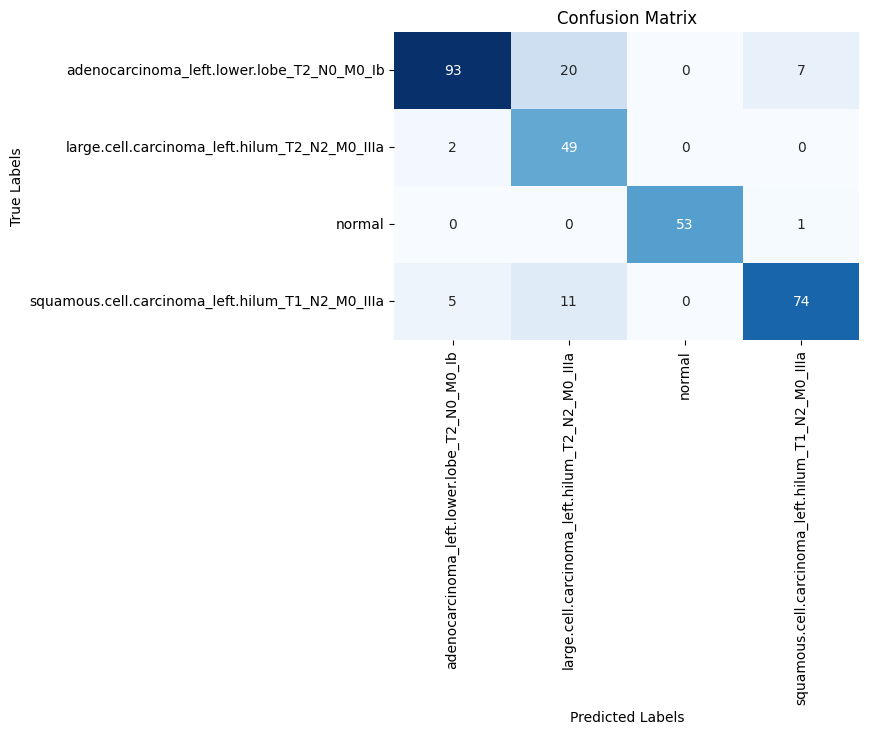

In [16]:
num_classes = len(class_names)
confusion_matrix = torch.zeros(num_classes, num_classes)
for t, p in zip(true_labels, predicted_labels):
    confusion_matrix[t, p] += 1

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [17]:
# --- Step 1: Gather True Labels and Predicted Probabilities ---
true_labels = []
predicted_probs = []

# Ensure model is in evaluation mode
model.eval()

# Disable gradient computation
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Processing test batches"):
        images = images.to(next(model.parameters()).device)
        outputs = model(images)  # Assuming model outputs logits or probabilities
        # If outputs are logits, apply softmax
        probabilities = torch.softmax(outputs, dim=1)
        
        predicted_probs.append(probabilities.cpu().numpy())
        true_labels.append(labels.cpu().numpy())

# Concatenate batches
predicted_probs = np.concatenate(predicted_probs, axis=0)  # shape: (n_samples, n_classes)
true_labels = np.concatenate(true_labels, axis=0)          # shape: (n_samples,)

# If true_labels are not one-hot encoded, convert them:
if true_labels.ndim == 1:
    num_classes = predicted_probs.shape[1]
    true_labels_onehot = label_binarize(true_labels, classes=range(num_classes))
else:
    num_classes = true_labels.shape[1]
    true_labels_onehot = true_labels

# Ensure we have a list of class names of the right length.
try:
    if len(class_names) != num_classes:
        classes = [f"Class {i}" for i in range(num_classes)]
except NameError:
    classes = [f"Class {i}" for i in range(num_classes)]

Processing test batches: 100%|██████████| 20/20 [00:01<00:00, 17.13it/s]


In [18]:
# --- Step 2: Compute ROC Curve and AUC for Each Class ---
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    # This may trigger UndefinedMetricWarning if there are no positive samples for a class.
    fpr[i], tpr[i], _ = roc_curve(true_labels_onehot[:, i], predicted_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# --- Step 3: Create the ROC Plot with Labels ---
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{classes[i]} (AUC = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

# --- Optional: Create a version without any labels (curves only) ---
fig, ax = plt.subplots(figsize=(10, 8))
for i, color in zip(range(num_classes), colors):
    ax.plot(fpr[i], tpr[i], color=color, lw=2)
ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("")
if ax.get_legend() is not None:
    ax.get_legend().remove()
plt.savefig("roc_plot_no_labels.png", bbox_inches='tight')
print("Saved ROC plot with only curves as 'roc_plot_no_labels.png'")
plt.show()

NameError: name 'classes' is not defined

<Figure size 1000x800 with 0 Axes>

In [ ]:
# --- Step 4: Save the ROC Data to an Excel File ---
excel_filename = "roc_data.xlsx"
with pd.ExcelWriter(excel_filename, engine='openpyxl') as writer:
    for i in range(num_classes):
        df = pd.DataFrame({
            'FPR': fpr[i],
            'TPR': tpr[i]
        })
        df['AUC'] = roc_auc[i]  # Same value for all rows
        # Excel sheet names are limited to 31 characters.
        sheet_name = classes[i][:31]
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"ROC metrics saved to {excel_filename}")